In [193]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [194]:
import numpy as np
import pandas as pd
from datascience import *

In [173]:
#importing table
#making new table for each risk level classification

health_table = Table().read_table('Health_Risk_Dataset.csv')
high = health_table.where('Risk_Level', are.equal_to('High'))
medium = health_table.where('Risk_Level', are.equal_to('Medium'))
normal = health_table.where('Risk_Level', are.equal_to('Normal'))
health_table.show(10)

Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Risk_Level
P0522,25,96,1,97,107,37.5,A,0,Medium
P0738,28,92,2,116,151,38.5,P,1,High
P0741,29,91,1,79,135,38.4,A,0,High
P0661,24,96,1,95,92,37.3,A,0,Medium
P0412,20,96,1,97,97,37.4,A,0,Low
P0679,20,91,2,121,98,37.8,P,1,Medium
P0627,16,90,1,116,96,38.4,A,0,Medium
P0514,17,90,1,118,107,39,A,0,Medium
P0860,31,88,1,87,107,40.7,P,0,High
P0137,18,98,1,127,72,36.6,A,0,Normal


In [174]:
#data exploration

health_table.group('Risk_Level')

Risk_Level,count
High,279
Low,255
Medium,306
Normal,160


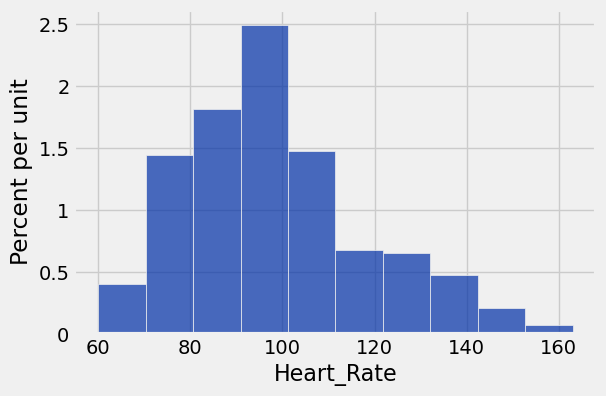

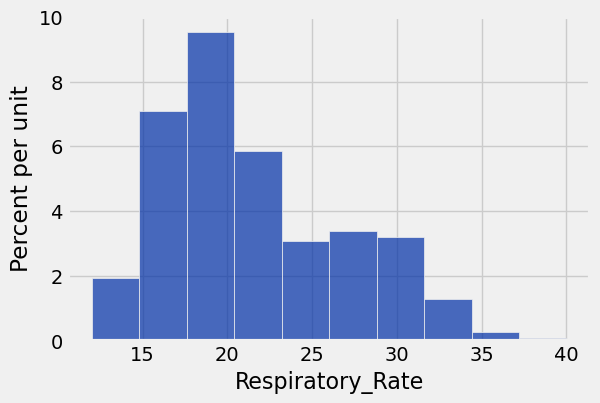

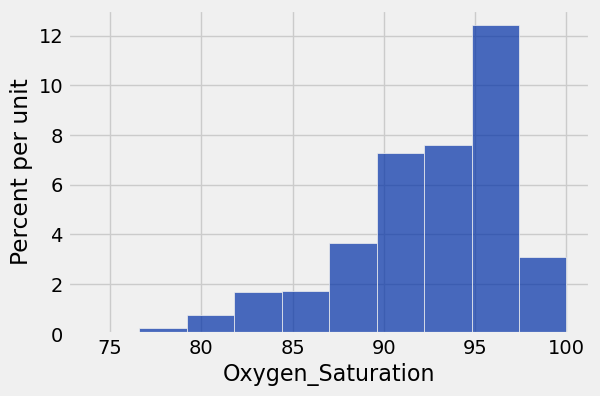

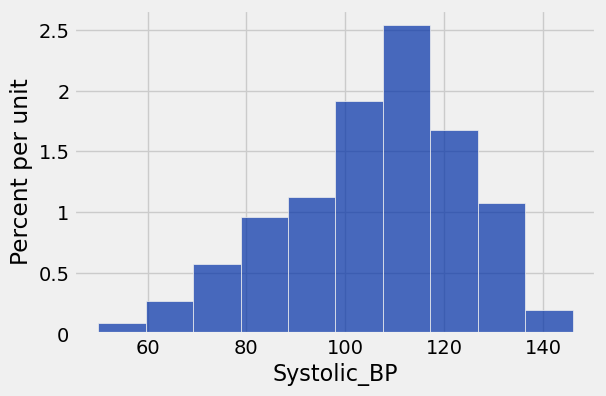

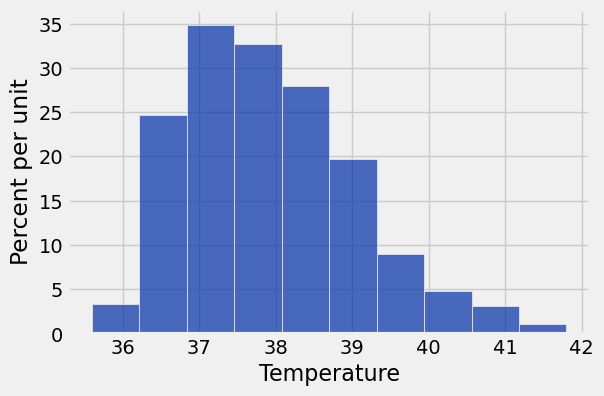

In [175]:
#more data exploration

health_table.hist('Heart_Rate')
health_table.hist('Respiratory_Rate')
health_table.hist('Oxygen_Saturation')
health_table.hist('Systolic_BP')
health_table.hist('Temperature')

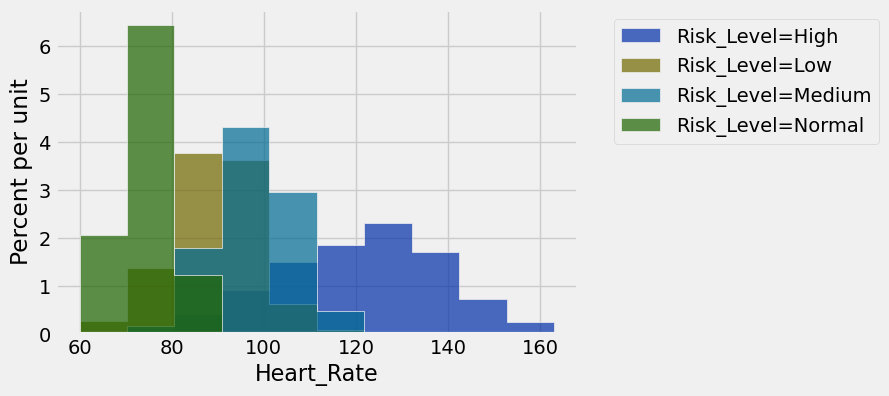

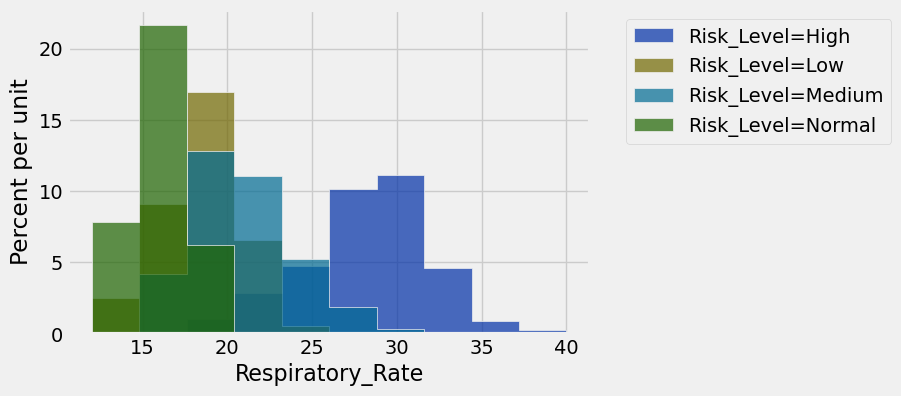

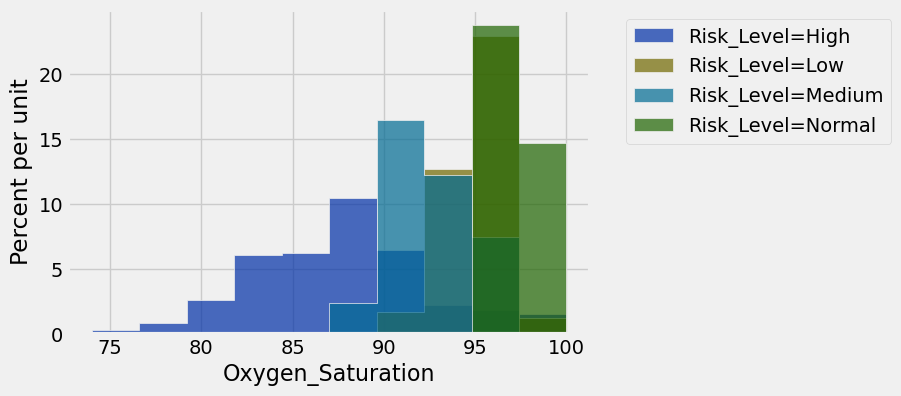

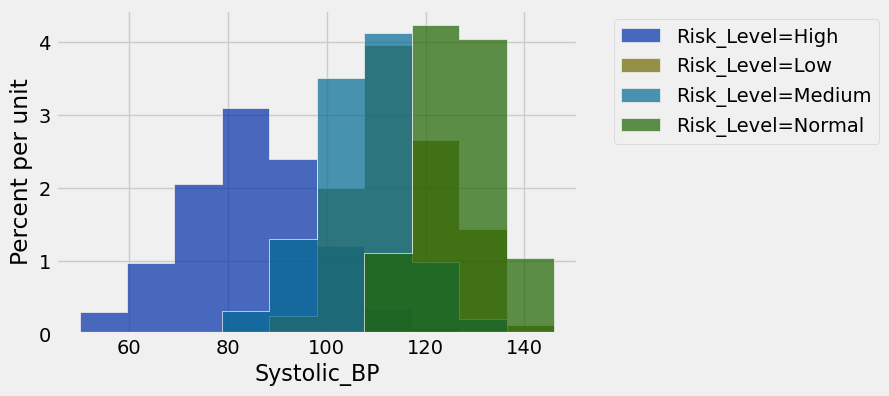

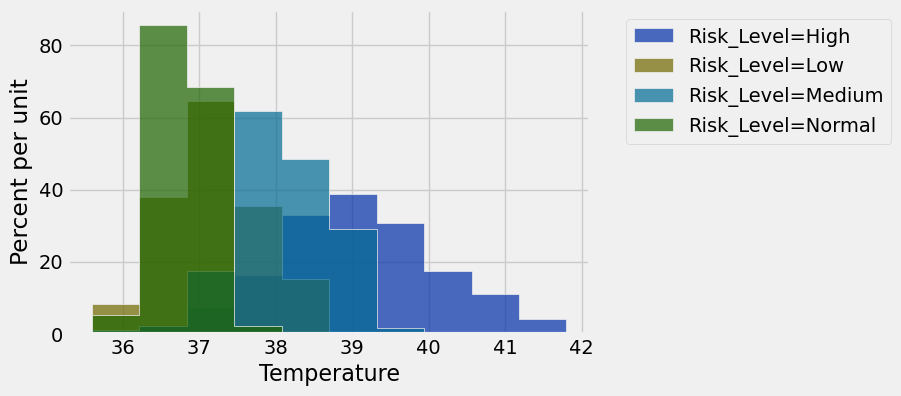

In [176]:
#comparing the distributions of each risk level

heart_rate_hist = health_table.hist('Heart_Rate', group='Risk_Level')
resp_rate_hist = health_table.hist('Respiratory_Rate', group='Risk_Level')
oxygen_sat = health_table.hist('Oxygen_Saturation', group='Risk_Level')
systolic_bp_hist = health_table.hist('Systolic_BP', group='Risk_Level')
temp_hist = health_table.hist('Temperature', group='Risk_Level')

In [178]:
#finding thresholds, the average of the normal collumn and everything below or above
#we identify where a dangerous level for a measurement would be, validating the statistic based off if they have an abnormal value

print('normal heart rate is less than' + ' ' + str(np.mean(normal.column('Heart_Rate'))))
print('normal respiratory rate is less than' + ' ' + str(np.mean(normal.column('Respiratory_Rate'))))
print('normal oxygen saturation is more than' + ' ' + str(np.mean(normal.column('Oxygen_Saturation'))))
print('normal systolic BP is more than' + ' ' + str(np.mean(normal.column('Systolic_BP'))))
print('normal temperature is less than' + ' ' + str(np.mean(normal.column('Temperature'))))

normal heart rate is less than 74.46875
normal respiratory rate is less than 15.9375
normal oxygen saturation is more than 97.3125
normal systolic BP is more than 126.6125
normal temperature is less than 36.78875


In [179]:
#using scikit to find the weights of each category and it's affect on the original classification
# using a random forest classifer, chatgpt helped but we can explain

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load your data
health_pd = pd.read_csv('Health_Risk_Dataset.csv')

# Features
feature_cols = ['Respiratory_Rate', 'Oxygen_Saturation', 'O2_Scale', 
                'Systolic_BP', 'Heart_Rate', 'Temperature', 
                'Consciousness', 'On_Oxygen']

X = health_pd[feature_cols]

# One-hot encode categorical features
categorical_cols = ['Consciousness', 'On_Oxygen', 'O2_Scale']
X = pd.get_dummies(X, columns=categorical_cols)

# Target
y = health_pd['Risk_Level']

# Split data (optional for training/validation)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

rf_model = RandomForestClassifier(random_state=0, n_estimators=100)
rf_model.fit(train_X, train_y)

import numpy as np

# Feature importance values
importances = rf_model.feature_importances_

# Match them to feature names
feature_names = X.columns
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.3f}")

Respiratory_Rate: 0.170
Oxygen_Saturation: 0.215
Systolic_BP: 0.185
Heart_Rate: 0.206
Temperature: 0.154
Consciousness_A: 0.009
Consciousness_C: 0.000
Consciousness_P: 0.000
Consciousness_U: 0.001
Consciousness_V: 0.003
On_Oxygen_0: 0.020
On_Oxygen_1: 0.020
O2_Scale_1: 0.007
O2_Scale_2: 0.008


In [180]:
#making the weights, multiplying the array by 100 because we are on an 100 points system

weights = (importances * 100)
resp_weight = weights.item(0)
oxy_weight = weights.item(1)
o2scale_weight = weights.item(2)
bp_weight = weights.item(3)
hr_weight = weights.item(4)
temp_weight = weights.item(5)
conc_weight  = weights.item(6) + weights.item(7) + weights.item(8) + weights.item(9) + weights.item(10)
onoxy_weight = weights.item(11) + weights.item(12)

In [148]:
np.sum(weights)

100.0

In [181]:
#reprinting of the normal threshold

print('normal heart rate is less than' + ' ' + str(np.mean(normal.column('Heart_Rate'))))
print('normal respiratory rate is less than' + ' ' + str(np.mean(normal.column('Respiratory_Rate'))))
print('normal oxygen saturation is more than' + ' ' + str(np.mean(normal.column('Oxygen_Saturation'))))
print('normal systolic BP is more than' + ' ' + str(np.mean(normal.column('Systolic_BP'))))
print('normal temperature is less than' + ' ' + str(np.mean(normal.column('Temperature'))))

normal_hr = np.mean(normal.column('Heart_Rate'))
normal_resp_rate = np.mean(normal.column('Respiratory_Rate'))
normal_oxysat = np.mean(normal.column('Oxygen_Saturation'))
normal_systbp = np.mean(normal.column('Systolic_BP'))
normal_temp = np.mean(normal.column('Temperature'))

normal heart rate is less than 74.46875
normal respiratory rate is less than 15.9375
normal oxygen saturation is more than 97.3125
normal systolic BP is more than 126.6125
normal temperature is less than 36.78875


In [150]:
#functions to find percentile
#the more function for when the value being more is abnormal, the less function for when the value being less is abnormal

def percentile_more(measurement, table, column):
    return np.sum(measurement >= table.column(column)) / len(table.column(column))

def percentile_less(measurement, table, column):
    return np.sum(measurement <= table.column(column)) / len(table.column(column))

points_more(22, health_table, 'Respiratory_Rate')

63.200000000000003

In [151]:
health_table.show(10)

Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Risk_Level
P0522,25,96,1,97,107,37.5,A,0,Medium
P0738,28,92,2,116,151,38.5,P,1,High
P0741,29,91,1,79,135,38.4,A,0,High
P0661,24,96,1,95,92,37.3,A,0,Medium
P0412,20,96,1,97,97,37.4,A,0,Low
P0679,20,91,2,121,98,37.8,P,1,Medium
P0627,16,90,1,116,96,38.4,A,0,Medium
P0514,17,90,1,118,107,39,A,0,Medium
P0860,31,88,1,87,107,40.7,P,0,High
P0137,18,98,1,127,72,36.6,A,0,Normal


In [183]:
#big meaty function
#multiplying the percentile by the weight and adding it to points if they are above/below the threshold
#for categorical variables adding the points according to importance or if the condition is met

def points(Patient_ID):
    patient = health_table.where('Patient_ID', are.equal_to(Patient_ID))
    points = 0
    if patient.column('Respiratory_Rate') > normal_resp_rate:
        points = percentile_more(patient.column('Respiratory_Rate').item(0), health_table, 'Respiratory_Rate') * resp_weight
    if patient.column('Heart_Rate') > normal_hr:
        points = points + percentile_more(patient.column('Heart_Rate').item(0), health_table, 'Heart_Rate') * hr_weight
    if patient.column('Oxygen_Saturation') < normal_oxysat:
        points = points + percentile_less(patient.column('Oxygen_Saturation').item(0), health_table, 'Oxygen_Saturation') * oxy_weight
    if patient.column('Systolic_BP') < normal_systbp:
        points = points + percentile_less(patient.column('Systolic_BP').item(0), health_table, 'Systolic_BP') * bp_weight
    if patient.column('Systolic_BP') > normal_temp:
         points = points + percentile_less(patient.column('Temperature').item(0), health_table, 'Temperature') * temp_weight
    if patient.column('O2_Scale').item(0) == 2:
        points = points + o2scale_weight
    if patient.column('Consciousness') == 'C':
        points = points + conc_weight
    elif patient.column('Consciousness') == 'U':
        points = points + conc_weight * 3/4
    elif patient.column('Consciousness') == 'P':
        points = points + conc_weight * 2/4
    elif patient.column('Consciousness') == 'V':
        points = points + conc_weight * 1/4
    elif patient.column('Consciousness') == 'A':
        points = points
    if patient.column('On_Oxygen') == 1:
        points = points + onoxy_weight
    return points

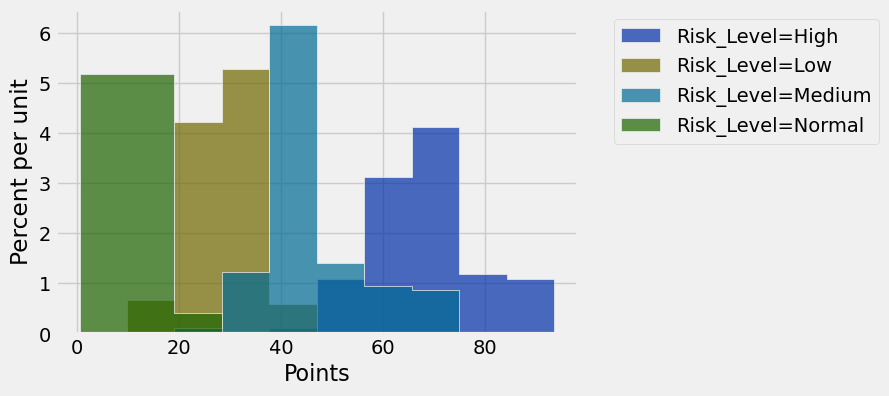

In [189]:
#checking function, making histogram to validate

point_table = health_table.with_column('Points', health_table.apply(points, 'Patient_ID'))
point_table.hist('Points', group='Risk_Level')

In [191]:
#reclassification function

def reclassification(points):
    if points >= 80:
        return "Urgent"
    elif points >= 60:
        return "High"
    elif points >= 40:
        return "Moderate"
    elif points >= 20:
        return "Low"
    else:
        return "Normal"

In [201]:
#final reclassified table

health_reclassified = point_table.with_column('Point Reclassification', point_table.apply(reclassification, 'Points')
).relabeled('Risk_Level', 'Original Risk')

In [202]:
health_reclassified

Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Original Risk,Points,Point Reclassification
P0522,25,96,1,97,107,37.5,A,0,Medium,45.9571,Moderate
P0738,28,92,2,116,151,38.5,P,1,High,74.3827,High
P0741,29,91,1,79,135,38.4,A,0,High,65.0664,High
P0661,24,96,1,95,92,37.3,A,0,Medium,41.1205,Moderate
P0412,20,96,1,97,97,37.4,A,0,Low,38.9527,Low
P0679,20,91,2,121,98,37.8,P,1,Medium,61.1072,High
P0627,16,90,1,116,96,38.4,A,0,Medium,35.1243,Low
P0514,17,90,1,118,107,39,A,0,Medium,38.5547,Low
P0860,31,88,1,87,107,40.7,P,0,High,65.029,High
P0137,18,98,1,127,72,36.6,A,0,Normal,6.53978,Normal
